W ramach projektu zaliczeniowego na podstawie danych dziennych przebiegających przez min. 8 lat (np. 2018-2025) należy:

- opisać empiryczny rozkład stóp zwrotu (wyświetlić statystyki opisowe oraz skomentować kluczowe wyniki).
- za pomocą min. dwóch testów normalności sprawdzić, czy dane dzienne spełniają założenie o normalności.
- dwoma wybranymi wersjami metody historycznej (prosta metoda historyczna, metoda historyczna z wagami, metoda uwzględniająca heteroskedastyczność poprzez EWMA lub model GARCH(1,1), metoda Monte Carlo)  w oparciu o 500-dniowe okno historyczne, zbudować szereg oszacowań 99% VaR i 99% ES.
- w oparciu o wyniki testów wstecznych (dla długości m = 250) odpowiedzieć na pytanie, czy wyznaczony VaR jest wyznaczony wiarygodnie (tj. nie jest zawyżony ani zaniżony). Czy owe wyniki pozwalają twierdzić, że obie metody dają wiarygodne oszacowania?
Uwaga: Każda praca będzie podlegała osobistej obronie (na żywo). W jej ramach będę weryfikował rozumienie kluczowych pojęć (definicja VaR i ES, rozumienie wybranych technik liczenia VaR i ES, rozumienie istoty testów wstecznych), a także sprawdzał samodzielność wykonanej pracy.

Praca zaliczeniowa ani jej recenzja NIE MOŻE  być wygenerowana przez sztuczną inteligencję (np. poprzez wygenerowanie tekstu interpretacji czy wygenerowanie znaczącej części kodu). W przypadku stwierdzenia takiego faktu podczas obrony, niezależnie od wyników uzyskanych w ramach projektu, wystawię ocenę 2.0.

In [45]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## Ładownaie danych

Ładuję dane z pliku csv. Są to dzienne zwroty Bitcoina w stosunku do dolara amerykańskiego na przestrzeni lat.

In [18]:
CSV_PATH = Path('../data/btcusd_d.csv')

data_btcusdt_frame_daily: pd.DataFrame = pd.read_csv(
        CSV_PATH,
        usecols=['datetime', 'open', 'high', 'low', 'close'],
        parse_dates=['datetime']
    )
# Ustawiam odpowiednio indeks
data_btcusdt_frame_daily.set_index('datetime').sort_index().astype('float64')  

# konwersja kolumny 'Data' na datetime, bo bez tego są błedne daty
data_btcusdt_frame_daily['datetime'] = pd.to_datetime(data_btcusdt_frame_daily['datetime'], errors='coerce')

# usuwam ewentualne błędne wiersze bez dat
data_btcusdt_frame_daily = data_btcusdt_frame_daily.dropna(subset=['datetime'])

# indeks i sortuje
data_btcusdt_frame_daily = (
    data_btcusdt_frame_daily
    .set_index('datetime')
    .sort_index()
    .astype('float64')
)

# Początkowe 10 wierszy
print(data_btcusdt_frame_daily.head(10))

               open     high      low    close
datetime                                      
2010-07-17  0.04951  0.04951  0.04951  0.04951
2010-07-18  0.08584  0.08584  0.08584  0.08584
2010-07-19  0.08080  0.08080  0.08080  0.08080
2010-07-20  0.07474  0.07474  0.07474  0.07474
2010-07-21  0.07921  0.07921  0.07921  0.07921
2010-07-22  0.05050  0.05050  0.05050  0.05050
2010-07-23  0.06262  0.06262  0.06262  0.06262
2010-07-24  0.05454  0.05454  0.05454  0.05454
2010-07-25  0.05050  0.05050  0.05050  0.05050
2010-07-26  0.05600  0.05600  0.05600  0.05600


## Wykres Bitcoina

Na wstępie narysukę wykres ceny Bitcoina, by sprawdzić czy dane wyglądają poprawnie i czy nie ma jakiegoś problemu z nimi.

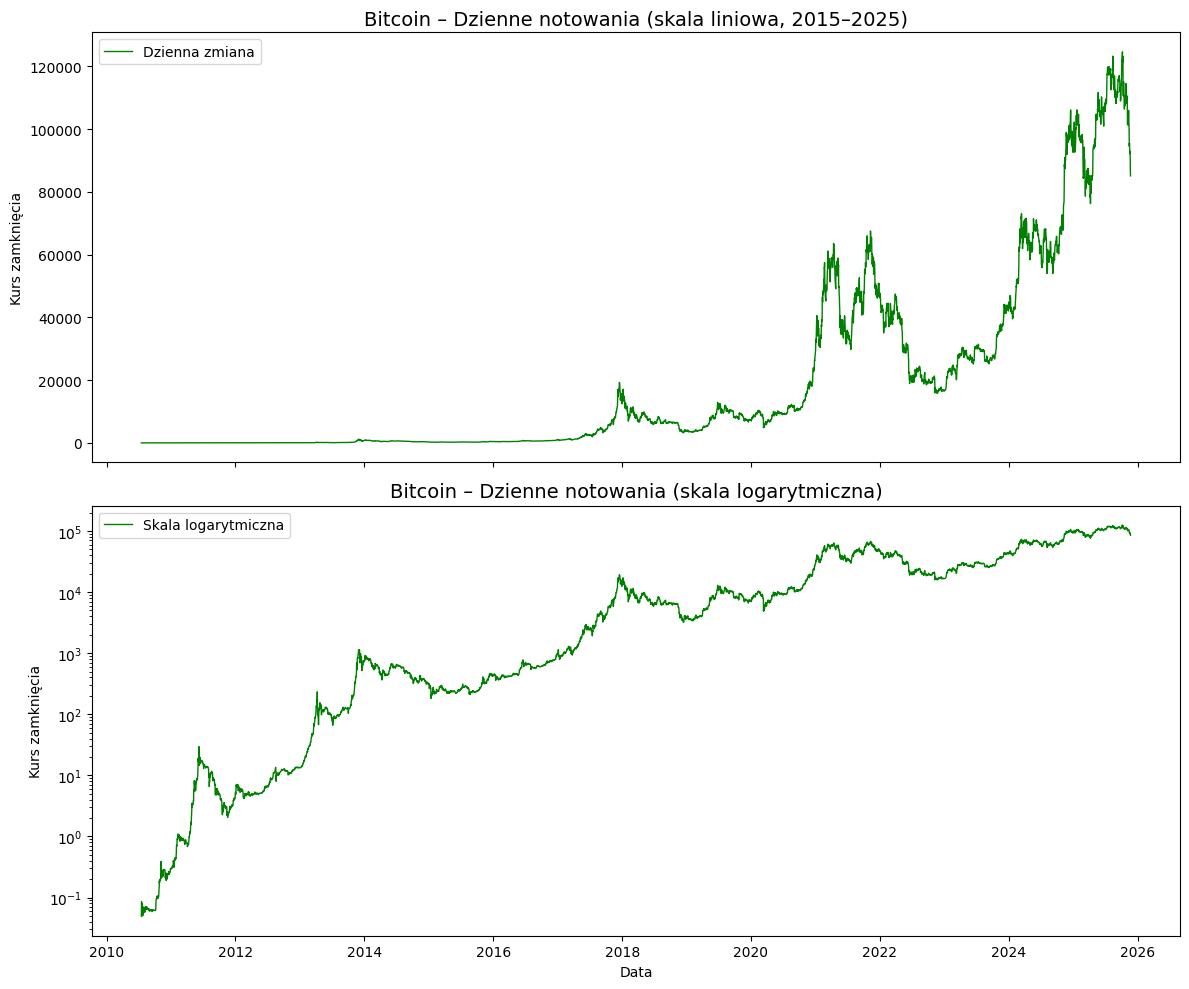

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

axes[0].plot(
    data_btcusdt_frame_daily.index,
    data_btcusdt_frame_daily['close'],
    label='Dzienna zmiana',
    color='green',
    linewidth=1
)
axes[0].set_title('Bitcoin – Dzienne notowania (skala liniowa, 2015–2025)', fontsize=14)
axes[0].set_ylabel('Kurs zamknięcia')
axes[0].legend()

axes[1].plot(
    data_btcusdt_frame_daily.index,
    data_btcusdt_frame_daily['close'],
    label='Skala logarytmiczna',
    color='green',
    linewidth=1
)
axes[1].set_title('Bitcoin – Dzienne notowania (skala logarytmiczna)', fontsize=14)
axes[1].set_xlabel('Data')
axes[1].set_ylabel('Kurs zamknięcia')
axes[1].set_yscale('log')
axes[1].legend()

plt.tight_layout()
plt.show()

Dane wyglądają poprawnie. Dodałem także wykres w skali logarytmicznej, by lepiej podejrzeć jak wyglądała zmienność Bitcoina w jego wczesnych latach.
Jak możemy zauważyć, początkowo zmienność była bardzo spora, a z czasem zaczyna ona maleć.
Nie jest to żadnym zaskoczeniem, tak często zachowują się młode aktywa, które dopiero z czasem i adopcją nabierają stabilności.

Z racji iż projekt ma zawierać zakres 2018-2025, przytnę teraz dane, jednak chciałbym zostawić ich trochę więcej, by móc zobaczyć jak zmieniał się VaR na przestrzeni czasu wraz ze stabilizującymi się notowaniami Bitcoina.
Dlatego mój zakres badania będzie od 2015 roku do 2025 roku (do daty do której pobrałem dane w tamtym momencie, czyli 21 listopada 2025).
Mam nadzieję, że wyłamanie się z zakresu i wydłużenie zakresu badania nie wpływnie negatywnie na ocenę.

In [20]:
START_DATE = "2015-01-01"
data_btcusdt_frame_daily_2015 = data_btcusdt_frame_daily.loc[START_DATE:].copy()

# Sprawdzam czy są braki w danych dziennych
start_date = data_btcusdt_frame_daily_2015.index.min()
end_date = data_btcusdt_frame_daily_2015.index.max()
expected_obs = (end_date - start_date).days + 1
actual_obs = len(data_btcusdt_frame_daily_2015)
missing_obs = expected_obs - actual_obs

print(
    f"Zakres dat po przycięciu: {start_date.date()}; {end_date.date()} "
    f"(liczba obserwacji: {actual_obs})"
)

print(f"Teoretycznie dziennych obserwacji powinno być: {expected_obs}. ")
if missing_obs > 0:
    print(f"Brakuje: {missing_obs} dni.")
else:
    print("Wszystkie dane są poprawne, nie brakuje żadnych dziennych zwrotów.")

print(data_btcusdt_frame_daily_2015.head())

# W dalszej części będę pracował na przyciętych danych
# data_btcusdt_frame_daily = data_btcusdt_frame_daily_2015

Zakres dat po przycięciu: 2015-01-01; 2025-11-21 (liczba obserwacji: 3978)
Teoretycznie dziennych obserwacji powinno być: 3978. 
Wszystkie dane są poprawne, nie brakuje żadnych dziennych zwrotów.
              open        high     low   close
datetime                                      
2015-01-01  322.31  324.997030  313.81  314.96
2015-01-02  314.54  319.999990  313.28  315.81
2015-01-03  315.80  315.990000  277.50  279.30
2015-01-04  279.30  288.740000  255.03  264.19
2015-01-05  264.04  280.410588  263.75  274.84


## Stopy zwrotu Bitcoina

Teraz tworzę funkcje pomocnicze, które pozwolą mi na łatwe wyznaczanie stóp zwrotu (prostą i logarytmiczną)
Wykorzystuję do tego funkcje pomocnicze z poprzednich ćwiczeń z tą różnicą, iż zamiast zwracać zwroty w procentach, będę je zwracac w ułamkach.
W dalszej części projektu skupię się na analizie **stóp logarytmicznych**.

In [21]:
def compute_returns(series: pd.Series) -> pd.DataFrame:
    returns = pd.DataFrame(index=series.index)
    returns["simple_frac"] = (series - series.shift(1)) / series.shift(1)
    returns["log_frac"] = np.log(series / series.shift(1))
    return returns

def plot_returns(df: pd.DataFrame, title: str):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df.index, df["simple_frac"], label="Stopa prosta")
    ax.plot(df.index, df["log_frac"], label="Stopa logarytmiczna")
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Data")
    ax.set_ylabel("Stopa zwrotu (%)")
    ax.legend()

    plt.tight_layout()
    plt.show()

            simple_frac  log_frac
datetime                         
2025-11-12    -0.013629 -0.013723
2025-11-13    -0.019304 -0.019493
2025-11-14    -0.051138 -0.052492
2025-11-15     0.010595  0.010539
2025-11-16    -0.013963 -0.014061
2025-11-17    -0.021709 -0.021948
2025-11-18     0.008086  0.008054
2025-11-19    -0.015123 -0.015239
2025-11-20    -0.053713 -0.055210
2025-11-21    -0.017404 -0.017557


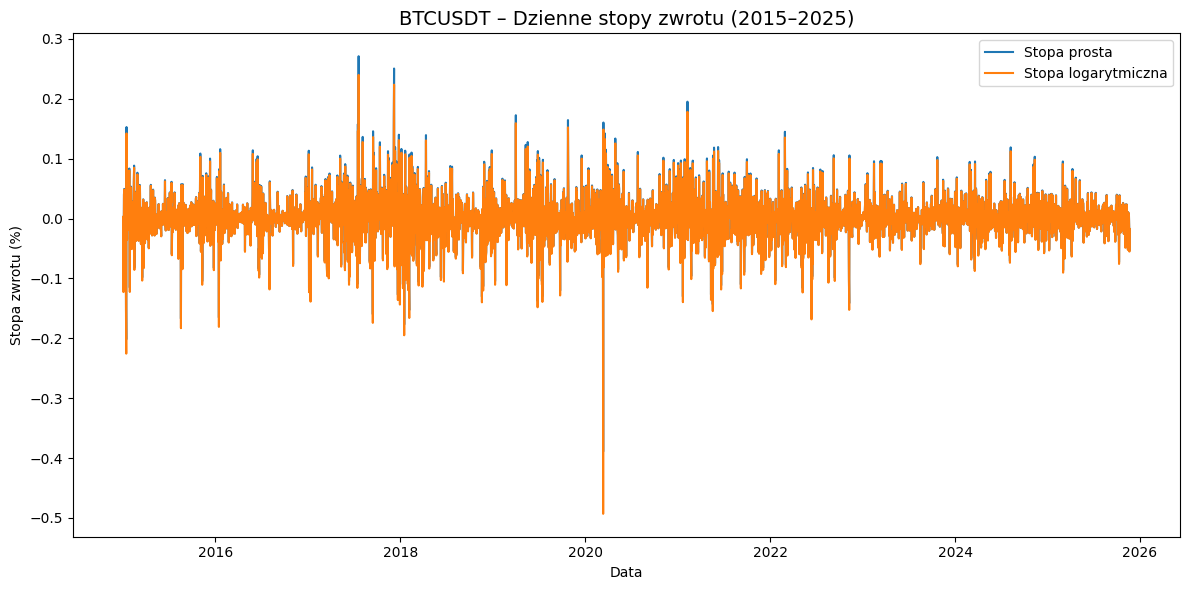

In [22]:
returns_daily = compute_returns(data_btcusdt_frame_daily_2015["close"])
returns_daily = returns_daily.dropna()
returns_daily_log = returns_daily["log_frac"]

print(returns_daily.tail(10))
plot_returns(returns_daily, "BTCUSDT – Dzienne stopy zwrotu (2015–2025)")

Jak możemy zauważyć po wykresie zwrotów, Bitcoin charakteryzuje się bardzo mocnymi wahaniami wyceny. Co jest jednocześnie jego plusem i minusem w zależności jakeigo typu inwestorem jesteśmy.
Można też bardzo szybko zauważyć crash covidowy, który spowodował mocne spadki na giełdach. Nie omineło to także Bitcoina, gdzie możemy zauważyć ~50% spadek według stopy logarytmicznej.

In [23]:
# Statystyki opisowe dziennych stóp zwrotu (w %)
returns_pct = returns_daily[["simple_frac", "log_frac"]] * 100
returns_daily_log_pct = returns_pct["log_frac"]

stats_desc = returns_pct.describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]).T
tail_desc = returns_pct.agg(['skew', 'kurtosis']).T

print("Statystyki opisowe dziennych stóp zwrotu (w %):")
print(stats_desc.to_string(float_format=lambda x: f"{x:0.4f}"))

print("\nSkośność i kurtoza:")
print(tail_desc.to_string(float_format=lambda x: f"{x:0.2f}"))

Statystyki opisowe dziennych stóp zwrotu (w %):
                count   mean    std      min       1%      5%    50%    95%     99%     max
simple_frac 3977.0000 0.2061 3.5967 -38.9320 -10.4621 -5.5213 0.1301 5.7446 10.6091 27.1104
log_frac    3977.0000 0.1408 3.6239 -49.3182 -11.0508 -5.6796 0.1300 5.5856 10.0832 23.9886

Skośność i kurtoza:
             skew  kurtosis
simple_frac -0.13      7.92
log_frac    -0.78     12.70


Od razu po opisie rozkładu możemy zauważyć, iż istnieje spora różnica między największym zyskiem a największą stratą. Jest to różnica około dwukrotna.
Na wstępie wytłumaczenie mogłoby być takie, że statystykę zniekształca nam "covidowy crash".
Jednak jeśli sprawdzimy percentyle 1% i 99%, a nie tylko ekstrema, zauważymy, iż ten efekt nadal się utrzymuje.

* 1%: `-11.0508`
* 99%: `10.0832`

Jest to różnica około 1 punktu procentowego, co na rynkach finansowych jest wartością dość znaczną.
Przeanalizujemy jeszcze skośność i kurtozę, by potwierdzić, iż częściej występują ekstremalne spadki niż zyski.

Jednak też już teraz mogę założyć, iż ta analiza potwierdzi powyższą tezę. Wynika to z faktu, iż rynki często charakteryzują się tym, że inwestorzy częściej ekstremalnie panikują, powodując jeszcze mocniejsze spadki (boją się większych strat niż te, co mają, dlatego sprzedają), niż reagują na ekstremalne wzrosty. Tutaj działa po prostu ludzka psychika.

**Skośność:**
`-0.78`
Jest wyraźnie ujemna, co oznacza, że "ogon" wykresu po lewej stronie (straty) jest dłuższy i "grubszy" niż po prawej (zyski). Mimo że Bitcoin kojarzy się z wielkimi wzrostami, statystyka ta mówi, że ekstremalne spadki są bardziej prawdopodobne (lub silniejsze) niż ekstremalne wzrosty o tej samej skali.
Sugerowało by to tendencję do występowania tzw. "crashów", czyli nagłych, głębokich załamań cenowych.

**Kurtoza:**
`12.70`
Dla rozkładu normalnego kurtoza wynosi 3 (dla wygody odejmuje się tę wartość i tworzy tzw. "współczynnik ekscesu").
Nasz wynik w porównaniu do tej trójki jest ogromny. Taki wynik oznacza, iż nasz rozkład jest leptokurtyczny (kurtoza > 0), co mówi, że intensywność wartości skrajnych jest większa niż dla rozkładu normalnego.

Obie miary kurtoza i skośność potwierdzają nam, że na rynku Bitcoina często występują skrajne zwroty.

## Histogram stóp zwrotów

In [30]:
# Histogram rozkładu dziennych stóp zwrotu logarytmicznych (w %)
quantiles = returns_daily_log_pct.quantile([0.01, 0.05, 0.5, 0.95, 0.99])

fig_int = px.histogram(
    returns_daily_log_pct,
    nbins=100,
    histnorm="probability density",
    title="Interaktywny histogram stóp zwrotu logarytmicznych (w %)",
    labels={"value": "Dzienna stopa zwrotu (%)"},
)
fig_int.add_vline(x=quantiles.loc[0.01], line_dash="dash", line_color="crimson", annotation_text="1%")
fig_int.add_vline(x=quantiles.loc[0.05], line_dash="dash", line_color="orange", annotation_text="5%")
fig_int.add_vline(x=quantiles.loc[0.95], line_dash="dash", line_color="royalblue", annotation_text="95%")
fig_int.add_vline(x=quantiles.loc[0.99], line_dash="dash", line_color="navy", annotation_text="99%")
fig_int.update_layout(bargap=0.02, showlegend=False)
fig_int.show()

To histogramie widzimy, iż jednak covidowy spadek jest sporym outlinerem. Dlatego dla testu usunę go i jeszcze raz spradzę skośność i kurtozę czy faktycznie sprzyja częstszym drasrycznym spadkom, czy jednak to było tylko przez tego jednego outlinera.

## Histogram stóp zwrotów bez outlinera (Covidowego Crasha)

In [31]:
# Statystyki zwrotów bez największego ujemnego zwrotu z 2020 r. (w %)
covid_min_idx = returns_daily_log_pct.loc['2020'].idxmin()
returns_pct_no_outliers = returns_pct.drop(index=covid_min_idx)

stats_desc_no = returns_pct_no_outliers.describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]).T
tail_desc_no = returns_pct_no_outliers.agg(['skew', 'kurtosis']).T

print(f'Liczba obserwacji po filtracji: {len(returns_pct_no_outliers)} ({len(returns_pct)} wcześniej)')
print('Statystyki opisowe (w %):')
print(stats_desc_no.to_string(float_format=lambda x: f"{x:0.4f}"))

print('Skośność i kurtoza (w %):')
print(tail_desc_no.to_string(float_format=lambda x: f"{x:0.2f}"))

Liczba obserwacji po filtracji: 3976 (3977 wcześniej)
Statystyki opisowe (w %):
                count   mean    std      min       1%      5%    50%    95%     99%     max
simple_frac 3976.0000 0.2160 3.5432 -20.1999 -10.4024 -5.5029 0.1306 5.7448 10.6104 27.1104
log_frac    3976.0000 0.1532 3.5384 -22.5646 -10.9842 -5.6602 0.1305 5.5858 10.0844 23.9886
Skośność i kurtoza (w %):
             skew  kurtosis
simple_frac  0.19      4.85
log_frac    -0.16      4.66


Sam rozkład zwrotów percentyli jest niemal identyczny, czego można było się spodziewać, bo usuneliśmy tylko jedną obserwację.
Jednak widać, że wpłyneło to mocno na wartości skośnści i kurtozy.
			
**Skośność**
Przed: -0.78
Po: -0.07

**Kurtoza**
Przed: 12.70
Po: 1.51

Są to bardzo spore różnice, więc w dalszej analizie warto mieć to z tyłu głowy co może wpływać na być może jakieś nieprzewidziane i zaskakujące wyniki.

In [32]:
returns_pct_no_outliers_log = returns_pct_no_outliers['log_frac']
quantiles_no = returns_pct_no_outliers_log.quantile([0.01, 0.05, 0.95, 0.99])
fig_int = px.histogram(
    returns_pct_no_outliers_log,
    nbins=120,
    histnorm='probability density',
    title='Interaktywny histogram stóp zwrotu logarytmicznych (bez wartości odstających)',
    labels={'value': 'Dzienna stopa zwrotu (%)'},
)
fig_int.add_vline(x=quantiles_no.loc[0.01], line_dash='dash', line_color='crimson', annotation_text='1%')
fig_int.add_vline(x=quantiles_no.loc[0.05], line_dash='dash', line_color='orange', annotation_text='5%')
fig_int.add_vline(x=quantiles_no.loc[0.95], line_dash='dash', line_color='royalblue', annotation_text='95%')
fig_int.add_vline(x=quantiles_no.loc[0.99], line_dash='dash', line_color='navy', annotation_text='99%')
fig_int.update_layout(bargap=0.03, showlegend=False)
fig_int.show()


## Testy normalności rozkładu logarytmicznych stóp zwrotu

Teraz aby sprawdzić normalnosć wyników przeprowadzę 4 testy normalności, będą to
- Test Jarque-Bera (JB)
- Test Shapiro-Wilka
- Test Andersona-Darlinga
- Test Kołmogorowa-Smirnowa

In [33]:
import pandas as pd
import scipy.stats as st


def run_tests(series):
    mu, sigma = series.mean(), series.std(ddof=1)

    results = []

    # 1. JB
    jb_stat, jb_p = st.jarque_bera(series)
    results.append(
        {
            "Test": "Jarque-Bera",
            "p-value": f"p={jb_p:}",
            "Czy normalny?": "NIE" if jb_p < 0.05 else "TAK",
        }
    )

    # 2. Shapiro-Wilk
    sw_stat, sw_p = st.shapiro(series)
    results.append(
        {
            "Test": "Shapiro-Wilk",
            "p-value": f"p={sw_p:}",
            "Czy normalny?": "NIE" if sw_p < 0.05 else "TAK",
        }
    )

    # 3. Kołmogorow-Smirnow
    ks_stat, ks_p = st.kstest(series, "norm", args=(mu, sigma))
    results.append(
        {
            "Test": "Kolmogorow-Smirnow",
            "p-value": f"p={ks_p:}",
            "Czy normalny?": "NIE" if ks_p < 0.05 else "TAK",
        }
    )

    # 4. Anderson-Darling (nie ma p-value wprost)
    ad = st.anderson(series, dist="norm")
    # Dla poziomu istotności 5% indeks to 2 (w tablicy: 15%, 10%, 5%, 2.5%, 1%)
    ad_crit_5pct = ad.critical_values[2]
    ad_is_normal = ad.statistic < ad_crit_5pct
    results.append(
        {
            "Test": "Anderson-Darling",
            "p-value": f"Stat={ad.statistic:.2f} (Kryt={ad_crit_5pct:.2f})",
            "Czy normalny?": "TAK" if ad_is_normal else "NIE",
        }
    )

    df_res = pd.DataFrame(results)

    print(f"\nWyniki testów normalnosći logarytmicznych stóp zwrotu")
    print(df_res.to_string(index=False))

run_tests(returns_daily_log_pct)


Wyniki testów normalnosći logarytmicznych stóp zwrotu
              Test                  p-value Czy normalny?
       Jarque-Bera                    p=0.0           NIE
      Shapiro-Wilk  p=4.920491652000817e-44           NIE
Kolmogorow-Smirnow p=1.2620485025175827e-34           NIE
  Anderson-Darling   Stat=83.33 (Kryt=0.79)           NIE


Tak jak możemy wyczytać z wyników, żaden test nie potwierdził normalności rozkładu stóp zwrotu.
Było to do przewidzenia, gdyż aktywa przeważnie nie posiadają stóp zwrotu z rozkładem normalnym, a tmy bardziej można było się tego spodziewać bo świeżym aktywie.

Jarque-Bera daje wartość zera. Jest to wartość spodziewana po tym jak wygląda nasza skośność i kurtoza rozkładu.
Kolejnme dwa tetsy Shapiro-Wilk i Kolmogorow-Smirnow dają wartości niemal bliskie zeru.

Test Anderson-Darling także odrzuca tezę o normalności. Widzimy sporą różnicę między statystyką testu a wartością krytyczną dla poziomu istotności 5%. Moglismy się tego spodizewać bo już poprzednie testy wskazywały nam, że normlaności rozkładu jest definitywnie odrzucana.

Podsumowując, tesy pokazują, że **rozkład logarytmicznych zwrotów nie jest normalny**

## VaR / ES (99%, okno 500)

Teraz zprzechodzimy do sekcji wyzanczania VaR i ES
Definiuję zmienne pomocnicze którę będę wykorzystywać przez resztę analizy

In [39]:
WINDOW = 500 # ile dni bierzemy pod uwagę, do wyliczenia VaR/ES
QUANTILE_LEVEL = 0.99  # Czyli 99% VaR
QUANTILE_LEVEL_PERCENTAHE = QUANTILE_LEVEL * 100 # Zamiana na procenty, pomocnicza

losses_daily_log_values = -returns_daily_log.values
losses_daily_log = -losses_daily_log_values

### EWMA (Exponentially Weighted Moving Average)

Wzór:
![image.png](attachment:image.png)
<!-- sigma_n^2 = lambda * sigma_{n-1}^2 + (1 - lambda) * u_{n-1}^2 -->

Gdzie:
- sigma_n^2 – bieżąca wariancja (prognoza zmienności).
- sigma_{n-1}^2 – poprzednia wariancja.
- u_{n-1} – ostatni log-zwrot
- lambda ∈ (0,1) – im wyższe, tym wolniej zapomina starą zmienność; klasycznie to 0.94 i taką też wartość użyjemy na start.


Kos poniżej jest podzielony na dwa bloki.
Pierwszy oblicza dynamiczną wariancję "ręcznie", a na jej podstawie Value at Risk (VaR) oraz Expected Shortfall (ES) przy użyciu modelu EWMA. Model ten nadaje większą wagę nowszym obserwacjom, dzięki czemu szybciej reaguje na zmieniającą się zmienność rynkową.

In [47]:
LAMBDA = 0.94 # Standardowa używana wartość lambda służąca (czynnik zanikania pamięci)

# tablica na wyniki (same zera na start)
sigmas = np.zeros(len(losses_daily_log_values))

# inicjalizacja
# musimy od czegoś zacząć dlatego biorę wariancję z pierwszych 500 dni jako wartość startową
current_var = np.var(losses_daily_log_values[:WINDOW])

# pętla licząca EWMA tak jak wedgług wzoru
for i in range(len(losses_daily_log_values)):
    # Zapisujemy obecną sigmę (pierwiastek z wariancji)
    sigmas[i] = np.sqrt(current_var)
    
    # Aktualizujemy wariancję na kolejny dzień
    # var_new = lambda * var_old + (1-lambda) * zwrot^2
    current_var = LAMBDA * current_var + (1 - LAMBDA) * (losses_daily_log_values[i]**2)

sigma_ewma = pd.Series(sigmas, index=returns_daily_log.index, name="Sigma EWMA")

# Obliczenie EWMA z Pandas (Dla porównania, bo ma wbudowane)
# alpha = 1 - lambda.
# adjust=False sprawia, że liczy to wg wzoru rekurencyjnego (jak w pętli).
# używamy .shift(1) ponieważ nasza pętla zapisuje sigmas[i] przed aktualizacją o losses_daily_log_values[i].
sigma_ewma_pandas = (
    returns_daily_log.pow(2)
    .ewm(alpha=1-LAMBDA, adjust=False)
    .mean()
    .shift(1)
    .pow(0.5)
)
sigma_ewma_pandas.name = "Sigma Pandas"

# góra: Zmienność EWMA (Sigma)
# dół: Dzienne Zwroty
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.05,
    subplot_titles=("Zmienność Dziennia EWMA (Sigma)", "Dzienne Stopy Zwrotu"),
    row_heights=[0.7, 0.3]
)

# Ręczna
fig.add_trace(go.Scatter(
    x=sigma_ewma.index,
    y=sigma_ewma * 100,
    mode='lines',
    name='Sigma EWMA (Ręczna)',
    line=dict(color='orange', width=2)
), row=1, col=1)

# Pandas (Weryfikacja)
fig.add_trace(go.Scatter(
    x=sigma_ewma_pandas.index,
    y=sigma_ewma_pandas * 100,
    mode='lines',
    name='Sigma EWMA (Pandas)',
    line=dict(color='blue', width=1.5, dash='dash')
), row=1, col=1)


# zwroty
fig.add_trace(go.Scatter(
    x=returns_daily_log.index,
    y=returns_daily_log * 100,
    mode='lines',
    name='Dzienne Zwroty',
    line=dict(color='gray', width=1),
    opacity=0.5
), row=2, col=1)

fig.update_layout(
    title=f"Model EWMA (lambda={LAMBDA}) – Zmienność vs Zwroty",
    template="plotly_white",
    hovermode="x unified",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    height=700
)

fig.update_yaxes(title_text="Zmienność [%]", row=1, col=1)
fig.update_yaxes(title_text="Zwrot [%]", row=2, col=1)

fig.show()